In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder

In [ ]:
pickle_path = "EP6_RCVs_2022_06_13.pkl"
df = pd.read_pickle(pickle_path)
df = df[df.EPG.notna()]
df = df[df.Country.notna()]
df.head()

In [3]:
# Handling missing values
df['Fname'] = df.apply(lambda row: row['FullName'].split()[0] if pd.isnull(row['Fname']) else row['Fname'], axis=1)
df['Lname'] = df.apply(lambda row: ' '.join(row['FullName'].split()[1:]) if pd.isnull(row['Lname']) and len(row['FullName'].split()) > 1 else row['Lname'], axis=1)

In [4]:

df['Party'].unique()
df = df[df['Party'].str.contains('[a-zA-Z]')]
# Convert 'Start' and 'End' columns to pandas datetime objects
df['Start'] = pd.to_datetime(df['Start'])
df['End'] = pd.to_datetime(df['End'])
# Define the reference date as the oldest date in your data
reference_date = df[['Start', 'End']].min().min()
# Calculate the number of days with respect to the reference date
df['Start'] = (df['Start'] - reference_date).dt.days
df['End'] = (df['End'] - reference_date).dt.days


In [5]:
df['Activ']= df['Activ'].map({'yes': 1, 'no': 0})
df.head()

,WebisteEpID,Fname,Lname,FullName,Activ,Country,Party,EPG,Start,End,...,6191,6192,6193,6194,6195,6196,6197,6198,6199,6200
1,28469.0,Adamos,ADAMOU,"ADAMOU, Adamos",1,Cyprus,Anorthotiko Komma Ergazomenou Laou - Aristera ...,Confederal Group of the European United Left -...,0,1990,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2,28302.0,Filip,ADWENT,"ADWENT, Filip",0,Poland,Liga Polskich Rodzin,Independence/Democracy Group,0,341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28975.0,Vittorio,AGNOLETTO,"AGNOLETTO, Vittorio",1,Italy,Partito della Rifondazione Comunista - Sinistr...,Confederal Group of the European United Left -...,0,1990,...,2.0,3.0,1.0,2.0,1.0,2.0,5.0,2.0,5.0,5.0
4,28367.0,Gabriele,ALBERTINI,"ALBERTINI, Gabriele",1,Italy,Forza Italia,Group of the European People's Party (Christia...,0,1990,...,1.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,5.0,5.0
5,28512.0,James Hugh,ALLISTER,"ALLISTER, James Hugh",1,United Kingdom,Traditional Unionist,Non-attached Members,0,1990,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0


In [6]:
# df = pd.get_dummies(df, columns=['Party'], prefix='')
# df.head()

In [7]:
# Similarity Functions : 
def dot_product_similarity(vector1, vector2):
    return np.dot(vector1, vector2) 


In [8]:
# Output data :
EPG_data = df['EPG']
Country_data = df['Country']

# Input Data : 
columns_to_drop = ['WebisteEpID','Fname','Lname','FullName','EPG','Country']
df.drop(columns=columns_to_drop,inplace=True)

dataset_matrix = df.values

print("Shape of input array :", dataset_matrix.shape)


Shape of input array : (925, 6202)


**SOMs**

In [9]:
# Define the parameters
start_value = 50
end_value = 0.1
num_values = 200
rows = 100
columns = dataset_matrix.shape[1]
weights = np.random.rand(rows, columns)

# Create an array of exponentially spaced values from start to end
exponential_values = np.geomspace(start_value, end_value, num=num_values)

# Convert the array to a list of discrete values
radiuses = [int(x) for x in exponential_values]



In [10]:
def BMU_2D(dataset,input_data):
  # Calculate the differences between the input and each row of the dataset
  distances = dataset - input_data
  differences = np.linalg.norm(dataset - input_data, axis=1)

  # Find the index of the row with the smallest difference
  min_index = np.argmin(differences)

      # Convert the 1D index to 2D coordinates
  x_bmu, y_bmu = min_index // 10, min_index % 10

  return min_index, x_bmu, y_bmu, distances

In [ ]:
from scipy.spatial.distance import cityblock
import matplotlib.pyplot as plt
import random
num_samples = 100
num_epochs = 100

print(weights)
for epoch in range(num_epochs):
  random_indices = [random.randint(0, len(dataset_matrix) - 1) for _ in range(num_samples)]
  for i in random_indices:
    input_sample = dataset_matrix[i]
    index_BMU, x_bmu, y_bmu, distances = BMU_2D(weights, input_sample)
    radius = radiuses[epoch]

    # Determine the range for neighbors within the 10x10 grid
    x_start = max(x_bmu - radius, 0)
    x_end = min(x_bmu + radius + 1, 10)
    y_start = max(y_bmu - radius, 0)
    y_end = min(y_bmu + radius + 1, 10)

    for x in range(x_start, x_end):
        for y in range(y_start, y_end):
            manhattan_distance = cityblock([x,y], [x_bmu,y_bmu])
            if manhattan_distance <= radius :
              index = x * 10 + y
              learning_rate = max(0.0001,0.1*(0.0001/0.1)**(epoch/num_epochs))
              weights[index] = weights[index] - learning_rate * distances[index]

print(weights)


/tmp/ipykernel_35913/221537682.py:36: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c=[color], cmap=cmap, s=20)


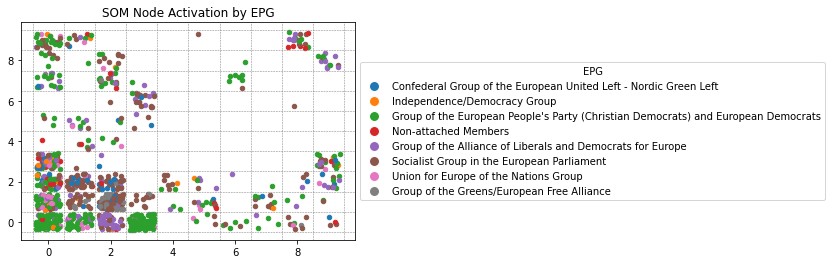

In [ ]:

from matplotlib.colors import to_rgba

party_names = EPG_data.unique()

# Create a 10x10 grid (assuming a 10x10 SOM)
grid_size = int(np.sqrt(len(weights)))
grid = np.zeros((grid_size, grid_size), dtype=int)


party_colors = ['#1f77b4',  # blue
                '#ff7f0e',  # orange
                '#2ca02c',  # green
                '#d62728',  # red
                '#9467bd',  # purple
                '#8c564b',  # brown
                '#e377c2',  # pink
                '#7f7f7f',  # gray
                '#FFFFFF']  

cmap = plt.matplotlib.colors.ListedColormap(party_colors)

default_color_code = len(party_colors) - 1
grid = np.full((100, 100), default_color_code, dtype=int)

# Find the BMU for each input data point and assign the corresponding color
for i in range(len(dataset_matrix)):
    input_sample = dataset_matrix[i]
    bmu_index, bmu_x, bmu_y, _ = BMU_2D(weights, input_sample)
    party_group = EPG_data.iloc[i]
    color_code = np.where(party_names == party_group)[0][0]
    color = party_colors[color_code]  # Use the index as a color code
    x_offset = np.random.uniform(-0.4, 0.4)
    y_offset = np.random.uniform(-0.4, 0.4)
    y = bmu_x + x_offset
    x = bmu_y + y_offset
    plt.scatter(x, y, c=[color], cmap=cmap, s=20)
    grid[bmu_x, bmu_y] = color_code 

# Generate a random color for each party dynamically
# party_colors = [(*np.random.rand(3), 0.5) for _ in party_names]

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=party, markersize=10, markerfacecolor=party_colors[i]) for i, party in enumerate(party_names)]
plt.legend(handles=legend_handles, title='EPG', loc='center left', bbox_to_anchor=(1, 0.5))

for x in range(11):  # Marqueurs de grille verticale
    plt.axvline(x=x - 0.5, color='gray', linestyle='--', linewidth=0.5)
for y in range(11):  # Marqueurs de grille horizontale
    plt.axhline(y=y - 0.5, color='gray', linestyle='--', linewidth=0.5)


plt.title("SOM Node Activation by EPG")
plt.show()

/tmp/ipykernel_35913/4166189035.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c=[color], cmap=cmap, s=20)


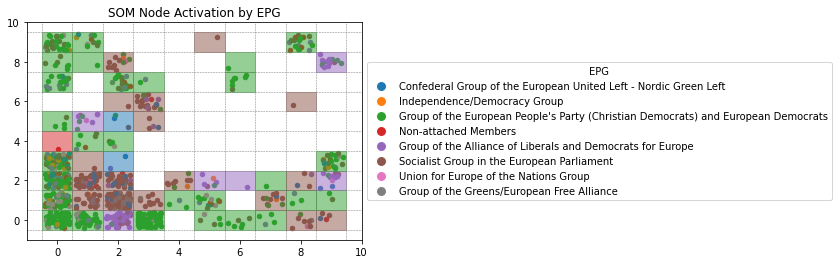

In [ ]:
from matplotlib.colors import to_rgba

party_names = EPG_data.unique()

# Create a 10x10 grid (assuming a 10x10 SOM)
grid_size = int(np.sqrt(len(weights)))
grid = np.zeros((grid_size, grid_size), dtype=int)


party_colors = ['#1f77b4',  # blue
                '#ff7f0e',  # orange
                '#2ca02c',  # green
                '#d62728',  # red
                '#9467bd',  # purple
                '#8c564b',  # brown
                '#e377c2',  # pink
                '#7f7f7f',  # gray
                '#FFFFFF']  

# Initialize the grid with default_color_code
default_color_code = len(party_colors) - 1  # Index of white color
grid = np.full((grid_size, grid_size), default_color_code, dtype=int)

# Count the occurrences of each color in each square
color_counts = np.zeros((grid_size, grid_size, len(party_colors)), dtype=int)

for i in range(len(dataset_matrix)):
    input_sample = dataset_matrix[i]
    bmu_index, bmu_x, bmu_y, _ = BMU_2D(weights, input_sample)
    party_group = EPG_data.iloc[i]
    color_code = np.where(party_names == party_group)[0][0]
    
    color_counts[bmu_x, bmu_y, color_code] += 1

# Plot the points first
for i in range(len(dataset_matrix)):
    input_sample = dataset_matrix[i]
    bmu_index, bmu_x, bmu_y, _ = BMU_2D(weights, input_sample)
    party_group = EPG_data.iloc[i]
    color_code = np.where(party_names == party_group)[0][0]
    color = party_colors[color_code]
    x_offset = np.random.uniform(-0.4, 0.4)
    y_offset = np.random.uniform(-0.4, 0.4)
    y = bmu_x + x_offset
    x = bmu_y + y_offset
    plt.scatter(x, y, c=[color], cmap=cmap, s=20)

# Assign the color with the maximum count to each square
for i in range(grid_size):
    for j in range(grid_size):
        # Check if the square has at least one point
        if np.sum(color_counts[i, j]) > 0:
            majority_color_code = np.argmax(color_counts[i, j])
            grid[i, j] = majority_color_code
            plt.fill_between([j - 0.5, j+1 - 0.5], i - 0.5, i+1 - 0.5, color=party_colors[majority_color_code], alpha=0.5)

# Overlay the grid on top of the points
cmap = ListedColormap(party_colors)
# plt.imshow(grid, cmap=cmap, interpolation='none', aspect='auto', alpha=0.5)

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=party, markersize=10, markerfacecolor=party_colors[i]) for i, party in enumerate(party_names)]
plt.legend(handles=legend_handles, title='EPG', loc='center left', bbox_to_anchor=(1, 0.5))

for x in range(11):  # Marqueurs de grille verticale
    plt.axvline(x=x - 0.5, color='gray', linestyle='--', linewidth=0.5)
for y in range(11):  # Marqueurs de grille horizontale
    plt.axhline(y=y - 0.5, color='gray', linestyle='--', linewidth=0.5)


plt.title("SOM Node Activation by EPG")
plt.show()

/tmp/ipykernel_35913/269642847.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x, y, c=[color], cmap=cmap, s=20)


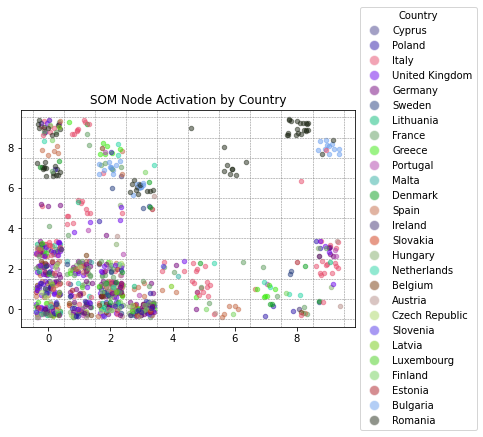

In [ ]:
from matplotlib.colors import to_rgba

country_names = Country_data.unique()

# Create a 10x10 grid (assuming a 10x10 SOM)
grid_size = int(np.sqrt(len(weights)))
grid = np.zeros((grid_size, grid_size), dtype=int)

country_colors = [(*np.random.rand(3), 0.5) for _ in country_names]
country_colors.append((1,1,1))

default_color_code = len(country_colors) - 1
grid = np.full((100, 100), default_color_code, dtype=int)

# Find the BMU for each input data point and assign the corresponding color
for i in range(len(dataset_matrix)):
    input_sample = dataset_matrix[i]
    bmu_index, bmu_x, bmu_y, _ = BMU_2D(weights, input_sample)
    country_group = Country_data.iloc[i]
    color_code = np.where(country_names == country_group)[0][0]
    color = country_colors[color_code]  # Use the index as a color code
    x_offset = np.random.uniform(-0.4, 0.4)
    y_offset = np.random.uniform(-0.4, 0.4)
    y = bmu_x + x_offset
    x = bmu_y + y_offset
    plt.scatter(x, y, c=[color], cmap=cmap, s=20)
    grid[bmu_x, bmu_y] = color_code 

# Generate a random color for each party dynamically


legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=party, markersize=10, markerfacecolor=country_colors[i]) for i, party in enumerate(country_names)]
plt.legend(handles=legend_handles, title='Country', loc='center left', bbox_to_anchor=(1, 0.5))

for x in range(11):  # Marqueurs de grille verticale
    plt.axvline(x=x - 0.5, color='gray', linestyle='--', linewidth=0.5)
for y in range(11):  # Marqueurs de grille horizontale
    plt.axhline(y=y - 0.5, color='gray', linestyle='--', linewidth=0.5)


plt.title("SOM Node Activation by Country")
plt.show()

***PCA***

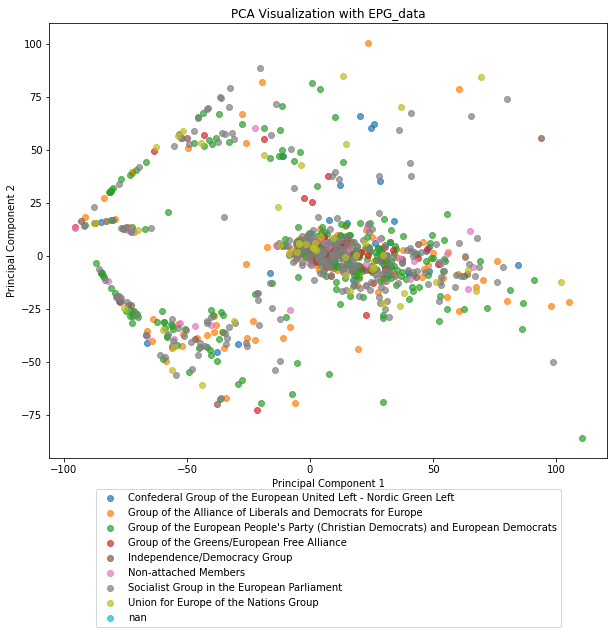

In [43]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Assuming you have your dataset_matrix, EPG_data, and Country_data defined
# dataset_matrix: np.array with shape (925, 6202)
# EPG_data: DataFrame with a single column and 925 rows
# Country_data: DataFrame with a single column and 925 rows

# Step 1: Standardize the data
mean = np.mean(dataset_matrix, axis=0)
std_dev = np.std(dataset_matrix, axis=0)
standardized_data = (dataset_matrix - mean) / std_dev

# Step 2: Apply PCA
n_components = 2  # You can choose the number of components you want
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(standardized_data)

# Step 3: Combine the PCA result with EPG_data
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
final_df = pd.concat([pca_df, EPG_data, Country_data], axis=1)

# Step 4: Convert categorical EPG_data to numerical values
le = LabelEncoder()
final_df['EPG_data_numeric'] = le.fit_transform(final_df['EPG'])

# Step 5: Define distinct colors for each category
category_colors = plt.cm.tab10(np.linspace(0, 1, len(le.classes_)))

# Step 6: Visualize the results with different colors for each category
plt.figure(figsize=(10, 8))

# Scatter plot with colors representing EPG_data
for category, color in zip(le.classes_, category_colors):
    subset = final_df[final_df['EPG'] == category]
    plt.scatter(subset['PC1'], subset['PC2'], label=category, color=color, alpha=0.7)

plt.title('PCA Visualization with EPG_data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='lower center',bbox_to_anchor=(0.5, -0.4))
plt.show()